In [15]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
# add project root to sys.path
sys.path.append(os.path.abspath(".."))
from cdrlib.pipeline import (
    features_weekday_weekend_shape, choose_k_and_fit, export_artifacts
)
ROOT = Path.cwd().parent
ART  = ROOT / "artifacts"
FIG  = ART / "figures"
ART.mkdir(exist_ok=True, parents=True)
FIG.mkdir(exist_ok=True, parents=True)

cdr = pd.read_parquet(ROOT / "milan_cdr_master.parquet")
cdr.head(3)

,square_id,time_interval,sms_in,sms_out,call_in,call_out,internet
0,1,2013-11-01 00:00:00,2.0843,1.1047,0.5919,0.4293,57.7990
1,1,2013-11-01 01:00:00,1.1637,0.7700,0.1906,0.1942,44.0469
2,1,2013-11-01 02:00:00,0.4156,0.3004,0.0279,0.1360,41.2071


In [9]:
df = cdr.copy()
df["dow"]  = df["time_interval"].dt.dayofweek
df["hour"] = df["time_interval"].dt.hour


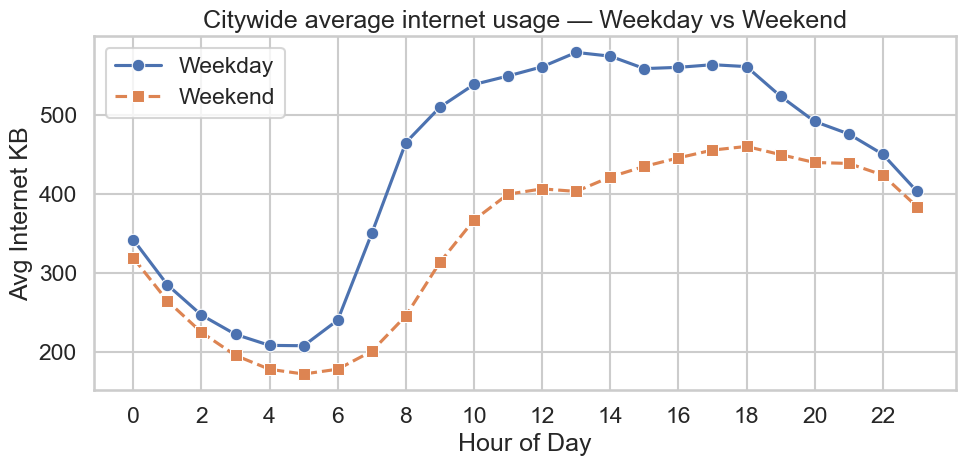

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\city_diurnal_weekday_weekend.png


In [ ]:
sns.set_theme(style="whitegrid", context="talk")

# Citywide average internet usage — Weekday vs Weekend
wk = (df[df["dow"].between(0,4)]
      .groupby("hour")["internet"].mean().reset_index())
we = (df[df["dow"].between(5,6)]
      .groupby("hour")["internet"].mean().reset_index())

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=wk, x="hour", y="internet", marker="o", label="Weekday", ax=ax)
sns.lineplot(data=we, x="hour", y="internet", marker="s", linestyle="--", label="Weekend", ax=ax)
ax.set_title("Citywide average internet usage — Weekday vs Weekend")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("Avg Internet KB")
ax.set_xticks(range(0,24,2)); ax.legend()
fig.tight_layout()
out = FIG / "city_diurnal_weekday_weekend.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out)


### 🌍 Citywide daily rhythm
- **Weekdays**: sharp rise after 7h, peak usage between **9–18h**, decline after 20h.  
- **Weekends**: smoother curve, later morning rise, sustained into **evening hours**.  
➡ Confirms Milan’s internet demand follows a **workday vs leisure** split.


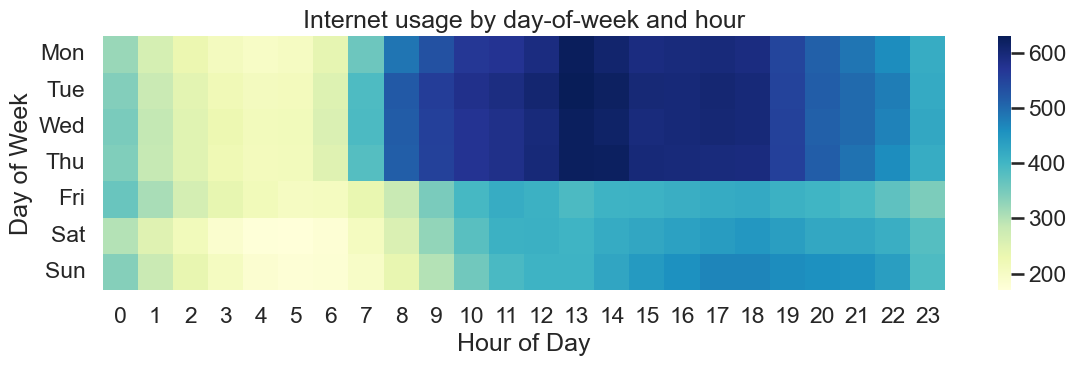

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\heatmap_dow_hour.png


In [ ]:

# Heatmap of average usage by day-of-week and hour
pivot = (df.groupby(["dow","hour"])["internet"].mean()
           .unstack("hour").fillna(0.0))

fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(pivot, cmap="YlGnBu", ax=ax)
ax.set_title("Internet usage by day-of-week and hour")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("Day of Week")
ax.set_yticks([i+0.5 for i in range(7)])
ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
fig.tight_layout()
out = FIG / "heatmap_dow_hour.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out)


### 📅 Weekly patterns
- **Mon–Fri**: consistent daytime peaks, strongest **midday/afternoon** usage.  
- **Sat–Sun**: lower morning load, but evenings show relatively higher activity.  
➡ Heatmap highlights the **weekday business pulse vs weekend leisure activity**.


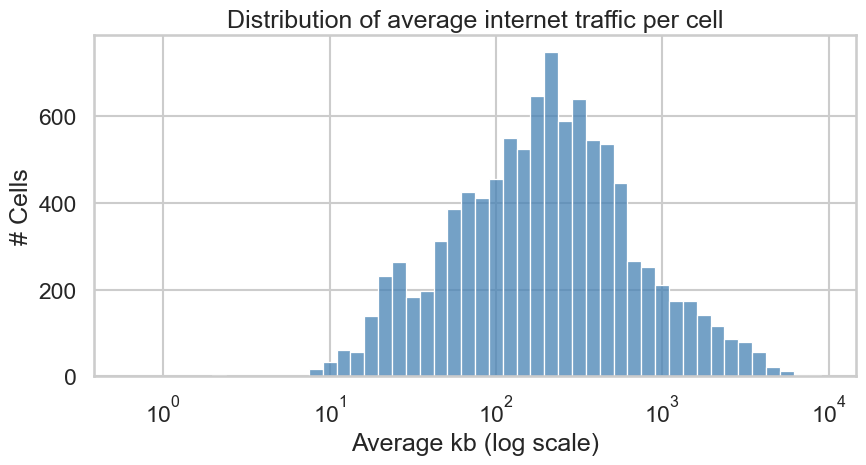

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\avg_volume_distribution.png


In [ ]:

# Distribution of average traffic per cell (log x-axis for skew)
avg_vol = (df.groupby("square_id")["internet"].mean().reset_index())

fig, ax = plt.subplots(figsize=(9,5))
sns.histplot(avg_vol["internet"], bins=50, log_scale=True, ax=ax, color="steelblue")
ax.set_title("Distribution of average internet traffic per cell")
ax.set_xlabel("Average kb (log scale)"); ax.set_ylabel("# Cells")
fig.tight_layout()
out = FIG / "avg_volume_distribution.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out)


### 📦 Distribution of cell activity
- Strongly **skewed distribution**: most cells have low/moderate traffic,  
  but a few hotspots generate **very high volumes**.  
- The log-scale histogram shows a **long right tail** typical of urban networks.  
➡ Justifies including **scale (log average volume)** in clustering.


In [13]:
'''
features_weekday_weekend_shape transforms the raw CDR into features suitable for clustering:

wkday: normalized weekday hourly profile (24 values per cell).

wkend: normalized weekend hourly profile (24 values per cell).

avg_vol: average internet volume per cell.

X: concatenation [wkday (24) + wkend (24) + log(avg_vol) (1)] = 49 features.

cell_ids: keeps track of which row corresponds to which grid cell.
'''
X, cell_ids, wkday, wkend, avg_vol = features_weekday_weekend_shape(cdr, value_col="internet")
X.shape  


(10000, 49)

In [ ]:
'''
choose_k_and_fit tries different cluster counts (from 3 to 8).

For each k:

Fits a KMeans model.

Computes Silhouette score (higher is better → separation & cohesion).

Computes Davies–Bouldin score (lower is better → compact clusters).

Picks the best k based on both metrics.

Returns:

best_k: chosen number of clusters.

metrics: evaluation values for the chosen model.

km: fitted KMeans model.

labels: cluster assignment for each cell.

grid: all scores across tested k values.
'''
best_k, metrics, km, labels, grid = choose_k_and_fit(X, k_min=3, k_max=8, random_state=42)
print("Chosen k:", best_k, metrics)

# Save k-evaluation table 
k_df = pd.DataFrame(grid, columns=["k","silhouette","davies_bouldin"]).sort_values("k")
k_eval_path = ART / "k_evaluation.csv"
k_df.to_csv(k_eval_path, index=False)
print("Saved:", k_eval_path)

Chosen k: 3 {'silhouette': 0.5317995869605949, 'db': 0.5741068403252102}
Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\k_evaluation.csv


In [ ]:
# Save cluster centers
import numpy as np

centers = km.cluster_centers_           # shape: (k, 49)
centers_shape = centers[:, :48]         # 24 weekday + 24 weekend
scales  = centers[:, 48]                # log avg volume

# Long/tidy format for convenient plotting
rows = []
for c in range(centers_shape.shape[0]):
    wk = centers_shape[c, :24]
    we = centers_shape[c, 24:48]
    for h in range(24):
        rows.append({"cluster": c, "phase": "Weekday", "hour": h, "share": wk[h]})
        rows.append({"cluster": c, "phase": "Weekend", "hour": h, "share": we[h]})
centers_long = pd.DataFrame(rows)

# Scales table
scales_df = pd.DataFrame({"cluster": range(centers_shape.shape[0]), "log_avg_volume": scales})

centers_long_path = ART / "cluster_centers_long.csv"
scales_path = ART / "cluster_scales.csv"
centers_long.to_csv(centers_long_path, index=False)
scales_df.to_csv(scales_path, index=False)
print("Saved:", centers_long_path)
print("Saved:", scales_path)


Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\cluster_centers_long.csv
Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\cluster_scales.csv


In [20]:
'''
Saves all the Power BI–ready CSVs + artifacts:

clusters_by_cell.csv → cluster ID + centroid per cell.

hourly_by_cell_with_cluster.csv → average hourly internet per cell + cluster.

hourly_city_totals.csv → citywide hourly averages.

Also merges with milan_cell_centroids.csv (lat/lon per cell).
'''
labels_df = pd.DataFrame({"square_id": cell_ids, "cluster": labels.astype("int16")})

export_dir = export_artifacts(
    ROOT, cdr, labels_df,
    centroids_csv=ROOT / "milan_cell_centroids.csv"  #  from Notebook 1
)
export_dir


WindowsPath('c:/Users/tempadmin.DESKTOP-C50JUBO/Desktop/DS Roadmap/CDR Mobility & Traffic Analytics Project/artifacts')

## 📌 Conclusions (Notebook 2 — Feature Engineering & Clustering Setup)

- We engineered a **49-dimensional feature set** per grid cell:  
  24-hour weekday profile + 24-hour weekend profile + log-average traffic volume.  

- We evaluated **KMeans clustering** across `k = 3..8` using Silhouette and Davies–Bouldin metrics.  
  The best trade-off was found at **k = 3**, balancing separation and compactness.  

- Each cell in Milan was assigned a **cluster label (0, 1, 2)**,  
  providing the foundation for spatial–temporal segmentation.  

- All artifacts (cell–cluster mapping, hourly by cell, citywide totals) were **exported for analysis** in the next stage.  

➡ Notebook 2 bridges raw CDR data and clustering, preparing clean inputs and outputs for detailed analysis in Notebook 3.
